# Legal Judgement Predictor - A classification task on BERT embeddings

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import seaborn as sns

path_to_datasets = 'embeddings_datasets/legal-bert-base-uncased/'

## Dataset

In [2]:
from src.echrdataset import ECHRDataset
from src.utils import create_dataset, load_dataset

#create_dataset(path_to_datasets)

train_dataset, test_dataset = load_dataset(path_to_datasets)

8480


## Data Understanding

(8480, 768)


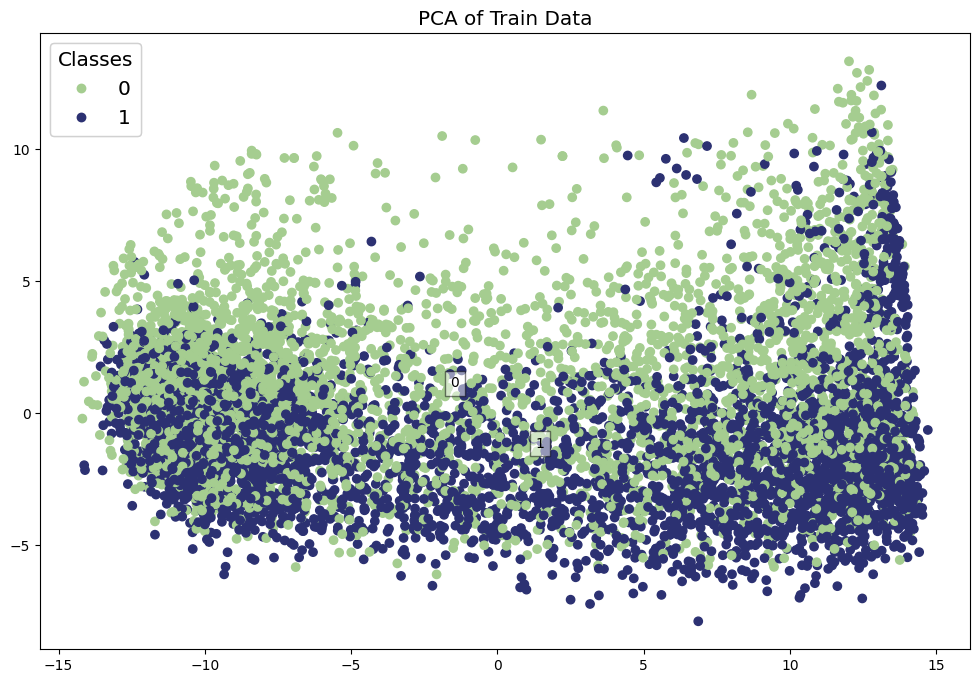

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

scaler = StandardScaler()
first_chunk_train = np.array([x[0].numpy() for x in train_dataset.data])
first_chunk_test = np.array([x[0].numpy() for x in test_dataset.data])

print(first_chunk_train.shape)

pca = PCA(n_components=2)
xpca = pca.fit_transform(first_chunk_train)

fig = plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(xpca[:, 0], xpca[:, 1], c=train_dataset.labels, cmap='crest')

# Get legend handles and labels
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", fontsize = 'x-large', title_fontsize = 'x-large')

# Add legend to the plot
plt.gca().add_artist(legend1)
# Get unique class labels
unique_labels = np.unique(train_dataset.labels)
# Add custom labels for class 0 and class 1
for label in unique_labels:
    plt.text(xpca[train_dataset.labels == label, 0].mean(), xpca[train_dataset.labels == label, 1].mean(), str(label),
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title('PCA of Train Data', fontsize='x-large')

plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(first_chunk_train, train_dataset.labels)
y_pred = rf_classifier.predict(first_chunk_test)
f1 = f1_score(test_dataset.labels, y_pred, average='weighted')
print(classification_report(test_dataset.labels, y_pred))
print("Random Forest F1:", f1)


### SVM

In [29]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(first_chunk_train, train_dataset.labels)
y_pred_svm = svm_classifier.predict(first_chunk_test)
f1 = f1_score(test_dataset.labels, y_pred_svm, average='weighted')
print(classification_report(test_dataset.labels, y_pred_svm))
print("SVM F1:", f1)

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1024
           1       0.81      0.91      0.86      1974

    accuracy                           0.80      2998
   macro avg       0.79      0.75      0.76      2998
weighted avg       0.80      0.80      0.79      2998

SVM F1: 0.7938613853836507


<Axes: >

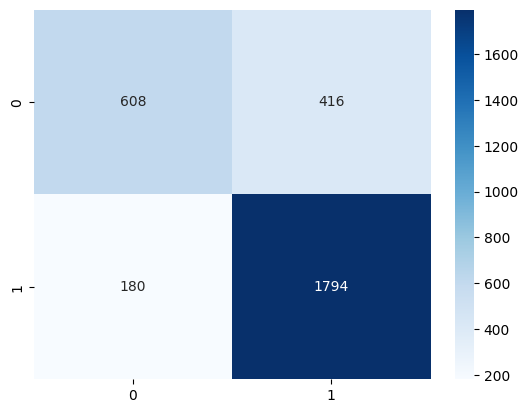

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.labels, y_pred_svm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')


### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(16,), max_iter=200, learning_rate='adaptive', random_state=42)
mlp_classifier.fit(first_chunk_train, train_dataset.labels)
y_pred_mlp = mlp_classifier.predict(first_chunk_test)
f1 = f1_score(test_dataset.labels, y_pred_mlp, average='weighted')
print(classification_report(test_dataset.labels, y_pred_mlp))
print("MLP F1:", f1)

## AttentionMLP Model

In [4]:
from src.utils import get_device
device = get_device()

train_dataset.data = train_dataset.data.to(device)
train_dataset.labels = train_dataset.labels.to(device)
train_dataset.attention_mask = train_dataset.attention_mask.to(device)

test_dataset.data = test_dataset.data.to(device)
test_dataset.labels = test_dataset.labels.to(device)
test_dataset.attention_mask = test_dataset.attention_mask.to(device)

train_dataset.data.device

Running on MPS


device(type='mps', index=0)

In [7]:
from src.attentionmlp import AttentionMLP
model = AttentionMLP(768, [768,16])
model = model.to(device)
results = model.k_fold ( 
                  criterion=nn.BCELoss(), 
                  train_dataset=train_dataset, 
                  lr=0.0001,
                  weight_decay=0.001,
                  k_folds=4, 
                  epochs=50, 
                  batch_size=64 )

Fold 1/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs:   6%|▌         | 3/50 [00:07<02:01,  2.59s/epoch, Train Loss=0.562, Val Loss=0.513, Val Acc=0.752, Val F1=0.752]


KeyboardInterrupt: 

In [ ]:
# print mean val loss and acc over fold 
loss = 0
acc = 0
f1 = 0
for key,value in results.items():
    loss += value['result']['best_val_loss']
    acc += value['result']['best_val_acc']
    f1 += value['result']['best_val_f1']

print('avg val loss: ', loss/len(results))
print('avg val acc: ', acc/len(results))
print('avg val f1: ', f1/len(results))

In [ ]:
fold = 1
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(results[fold]['stats']['train_losses'], label='Training loss')
ax[0].plot(results[fold]['stats']['val_losses'], label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results[fold]['stats']['val_accs'], label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

## RnnMLP Model

In [ ]:
from src.rnnmlp import RnnMLP
model = RnnMLP(768, 768, 2, 16, 1, dropout=0.1)
model = model.to(device)
results2 = model.k_fold( 
            criterion=nn.BCELoss(), 
            train_dataset=train_dataset, 
            lr=0.001, 
            weight_decay=1e-4, 
            k_folds=4, 
            epochs=50, 
            batch_size=128)

In [ ]:
# print mean val loss and acc over fold 
loss = 0
acc = 0
f1 = 0
for key,value in results2.items():
    loss += value['result']['best_val_loss']
    acc += value['result']['best_val_acc']
    f1 += value['result']['best_val_f1']

print('avg val loss: ', loss/len(results))
print('avg val acc: ', acc/len(results))
print('avg val f1: ', f1/len(results))

In [ ]:
fold = 4

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(results2[fold]['stats']['train_losses'], label='Training loss')
ax[0].plot(results2[fold]['stats']['val_losses'], label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results2[fold]['stats']['val_accs'], label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

## Test the best models

### AttentionMLP

In [5]:
from src.attentionmlp import AttentionMLP
model = AttentionMLP(768, [768,16])
model = model.to(device)
best_model, loss, acc, f1 = model.train_loop( 
                criterion=nn.BCELoss(),
                train_dataset=train_dataset,
                lr=0.0001,
                weight_decay=0.001,
                epochs=50,
                batch_size=64
                )

Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]/Users/lilf4p/Developer/hlt-project/src/attentionmlp.py:166: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  print(check_labels.sum())


424
tensor(219, device='mps:0')


Epochs:   2%|▏         | 1/50 [00:05<04:17,  5.26s/epoch, Train Loss=0.661, Val Loss=0.632, Val Acc=0.616, Val F1=0.597]


KeyboardInterrupt: 

In [7]:
torch.save(best_model, 'models/attention-mlp.pt')

In [41]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
best_model = AttentionMLP(768, [768,16])
best_model.load_state_dict(torch.load('models/attention-mlp.pt'))
best_model = best_model.to(device)

best_model.eval()
with torch.no_grad():
    predictions = []
    labels_topredict = []
    for inputs, att_masks, labels in test_loader:
        outputs = best_model(inputs, att_masks)
        predictions.append(torch.round(outputs).to('cpu'))
        labels_topredict.append(labels.to('cpu'))

    predictions = torch.cat(predictions).numpy()
    labels_topredict = torch.cat(labels_topredict).numpy()
    test_acc = accuracy_score(labels_topredict, predictions)
    test_f1 = f1_score(labels_topredict, predictions, average='weighted')

print(classification_report(labels_topredict, predictions))
print(f"Test Accuracy: {test_acc}")
print(f"Test F1: {test_f1}")

cm = confusion_matrix(labels_topredict, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

RuntimeError: Placeholder storage has not been allocated on MPS device!

### RnnMLP

In [8]:
from src.rnnmlp import RnnMLP
model = RnnMLP(768, 768, 2, 16, 1, dropout=0.1)
model = model.to(device)
best_model, loss, acc, f1 = model.train_loop( 
            criterion=nn.BCELoss(), 
            train_dataset=train_dataset, 
            lr=0.001, 
            weight_decay=1e-4,  
            epochs=50, 
            batch_size=128)

Epochs:   2%|▏         | 1/50 [01:03<52:10, 63.89s/epoch, Train Loss=0.707, Val Loss=0.697, Val Acc=0.483, Val F1=0]


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model = RnnMLP(768, 768, 2, 16, 1, dropout=0.1)
best_model.load_state_dict(torch.load('models/rnn-mlp.pt'))
best_model = best_model.to(device)

best_model.eval()
with torch.no_grad():
    predictions = []
    labels_topredict = []
    for inputs, att_masks, labels in test_loader:
        outputs = best_model(inputs, att_masks)
        predictions.append(torch.round(outputs).to('cpu'))
        labels_topredict.append(labels.to('cpu'))

    predictions = torch.cat(predictions).numpy()
    labels_topredict = torch.cat(labels_topredict).numpy()
    test_acc = accuracy_score(labels_topredict, predictions)
    test_f1 = f1_score(labels_topredict, predictions, average='weighted')

print(classification_report(labels_topredict, predictions))
print(f"Test Accuracy: {test_acc}")
print(f"Test F1: {test_f1}")

cm = confusion_matrix(labels_topredict, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')